# Fast and Cheap Wage Predictions 
7/15/19  
### Team: Hadi Morrow, Gaurav Munjal, Mahdi Shadkam-Farrokhi

## Problem Statement
Create a model to predict whether a person is likely to earn above \\$50k / year based on age, education, occupation, family, gender, etc.

Additionally, due to budget constraints, the sample size to train our model on is very limited, because it was relatively affordable to gather. (edited) 

## Executive Summary

To create a model to predict whether a person is likely to earn $50k / year, a sample of approximately 6,500 people were surveyed. The following details were recorded:

- Age
- Gender
- Working Class (Private, Gov't, Self Employed, etc.)
- Education
- Occupation
- Marital Status
- Family Relationship
- Capital Gain and Loss
- Native Country
- Wages

See data dictionary for precise classifications. Wages were classified as being above 50k, or less than or equal to 50k. Unknown data for any fields were classified as 'Other'.

A model was created using a vote of several individually tuned models together. Expand on Details...

The data was separated into training and testing data. The model was trained on the training data only. The model is about 91% accurate on training data and about 85% accurate on testing data,

## Table of Contents
- [Loading Data](#Loading Data)
- [EDA #1](#EDA #1)
- [Cleaning Data](#Cleaning Data)
    - [Handling Missing Values](#Handling Missing Values)
    - [Converting target: `wage`](#Converting target: `wage`)
- [## Feature engineering](#Feature engineering)
    -[Age ^ 2](Age ^ 2)
    -[### signed_log_abs_capital_flow](### signed_log_abs_capital_flow)
- [EDA #2](#EDA #2)
    - [### Correlations](### Correlations)
- [Model Preparation](#Model Preparation)
    -[### Metric of f1 score](#### Metric of f1 score)
- [Model Evaluation](#Model Evaluation)
- [Investigatin Model](#Investigatin Model)
- [Conclusions and Recommendations](#Conclusions and Recommendations)

## Loading Data

In [297]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.metrics         import r2_score, mean_absolute_error,mean_squared_error, roc_curve, accuracy_score
import warnings
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.ensemble        import VotingClassifier,RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
import xgboost as boost
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import StandardScaler, PolynomialFeatures
from sklearn import svm, tree
f1_scorer = make_scorer(f1_score)
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [311]:
df = pd.read_csv("data/cheap_train_sample.csv")
df_test = pd.read_csv("data/test_data.csv")

## EDA #1

In [299]:
df.shape

(6513, 14)

In [300]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
wage              0
dtype: int64

There are no null values. This is a complete dataset

We have a limited dataset, with ~6500 observations (the original data has over 45k observations)

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6513 entries, 0 to 6512
Data columns (total 14 columns):
age               6513 non-null int64
workclass         6513 non-null object
fnlwgt            6513 non-null int64
education         6513 non-null object
education-num     6513 non-null int64
marital-status    6513 non-null object
occupation        6513 non-null object
relationship      6513 non-null object
sex               6513 non-null object
capital-gain      6513 non-null int64
capital-loss      6513 non-null int64
hours-per-week    6513 non-null int64
native-country    6513 non-null object
wage              6513 non-null object
dtypes: int64(6), object(8)
memory usage: 712.4+ KB


The datatypes for all features are correct.

In [302]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,6513.000000,6.513000e+03,6513.000000,6513.000000,6513.000000,6513.000000
mean,38.529556,1.926640e+05,10.068478,1059.200829,92.108092,40.400891
std,13.684351,1.060173e+05,2.589238,7392.040587,413.710886,12.354685
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,27.000000,1.202380e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.815760e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.417530e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.366120e+06,16.000000,99999.000000,4356.000000,99.000000


We notice the `capital-gain` feature appears capped at 99999, which may incidate values above this amount.

## Cleaning Data

### Converting target: `wage`
The target variable is in a string form. We've chosen to convert these values into a binary 0 and 1.  

A 1 represents an observation with a wage over \\$50k, and a 0 represents an observation below \\$50k.

In [303]:
df['wage'] = df['wage'].map({' <=50K' : 0, ' >50K' : 1})

### Handling Missing Values
Many categorical features included missing data in the form of a " ?".
We ended up simply relabeling these categories as "Other" as not to remove any of the preciously limited data we had.

In [304]:
df[df['native-country'] == " ?"].head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
83,34,Private,198613,11th,7,Married-civ-spouse,Sales,Husband,Male,0,0,25,?,0
155,57,Private,140426,1st-4th,2,Married-spouse-absent,Other-service,Not-in-family,Male,0,0,35,?,0
269,36,Private,358682,Bachelors,13,Never-married,Exec-managerial,Other-relative,Male,0,0,50,?,0
325,42,Self-emp-not-inc,183765,Assoc-acdm,12,Married-civ-spouse,Sales,Husband,Male,0,0,40,?,0
498,20,Private,219266,HS-grad,9,Married-civ-spouse,Prof-specialty,Own-child,Female,0,0,36,?,0


In [312]:
df['native-country'][df['native-country'] == ' ?'] = 'Other'
df['workclass'][df['workclass'] == ' ?'] = 'Other'
df['occupation'][df['occupation'] == ' ?'] = 'Other'

In [313]:
df_test['native-country'][df_test['native-country'] == ' ?'] = 'Other'
df_test['workclass'][df_test['workclass'] == ' ?'] = 'Other'
df_test['occupation'][df_test['occupation'] == ' ?'] = 'Other'

## Feature engineering

### Age ^ 2
A common transformation is age^2, which can often yield better linearity with target variables.

In [315]:
df["age^2"] = df["age"] ** 2

In [314]:
df_test["age^2"] = df_test["age"] ** 2

### signed_log_abs_capital_flow
We wanted to capture a way of showi
ng the capital flow for an individual.  
We settled on the absolute different between `capital-gain` and `capital-loss` and then taking the log and reassigning the original sign.

In [317]:
flow = df["capital-gain"] - df["capital-loss"]
df["flow"] = flow
df["signed_log_abs_capital_flow"] = np.log(np.abs(flow) + 1) * np.sign(flow)
x_features = ["capital-gain","capital-loss", "wage"]

In [316]:
df_test_flow = df_test["capital-gain"] - df_test["capital-loss"]
df_test["flow"] = df_test_flow
df_test["signed_log_abs_capital_flow"] = np.log(np.abs(df_test_flow) + 1) * np.sign(df_test_flow)

In [308]:
total = df = pd.get_dummies(data = df_test.append(df.drop(columns=["wage"])), columns=df.select_dtypes("O").columns, drop_first=True)

## EDA #2

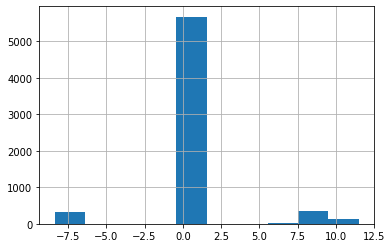

In [309]:
df["signed_log_abs_capital_flow"].hist();

Here, we see the distribution of the feature engineered `signed_log_abs_capital_flow` column.

### Correlations

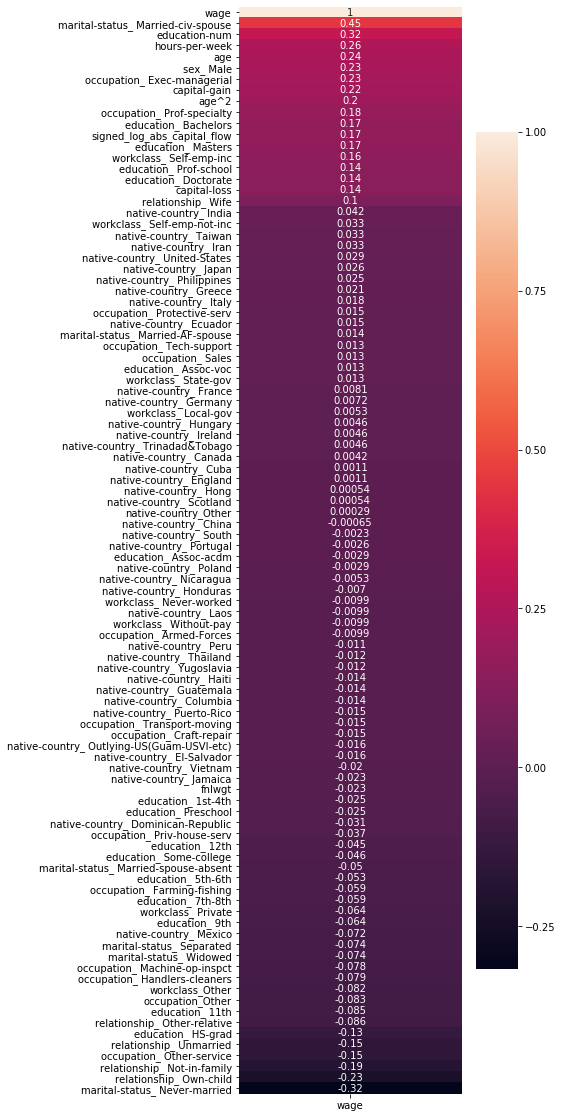

In [145]:
plt.figure(figsize=(5,20))
sns.heatmap(df.corr()[["wage"]].sort_values("wage", ascending = False), annot= True);

We find the strongest correlations to the target variable to be when an individual is married to a civil spouse, has high education num, works a high number of hours per week, and is male.

The strongest negative correlation is when an individual has never been married.

## Model Preparation

In [146]:
X = df.drop(columns=x_features)
y = df["wage"]

### Metric of f1 score
Because of imbalanced classes, we're interested in considering using the f1 score as our metric

In [ ]:
def f1_score(y_true, y_pred):
    '''Returns the f1 score given the true target values and model predictions'''
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    recall = TP / (TP + FN)
    prec = TP / (TP + FP)
    return 2 * (prec * recall) / (prec + recall)

In [ ]:
def f1_evalModel(model):
    model = model
    name = model.__class__.__name__
    
    train_pred  = model.predict(X_R_train)
    f1_train    = f1_score(y_R_train, train_pred)
    
    test_pred   = model.predict(X_R_test)
    f1_test     = f1_score(y_R_test, test_pred)
    return {
        "name":name,
        "train_f1" : f1_train,
        "test_f1" : f1_test,
        "f1_diff" : f1_train - f1_test
    }

In [329]:
def gridsearch(pipe, pipe_params, X, y):
    gs = GridSearchCV(pipe, param_grid = pipe_params, cv=5, n_jobs=-1, scoring="roc_auc")
    gs.fit(X_train, y_train)
    
    print("Train ROC AUC = {:.2%}".format(gs.score(X_train, y_train)))
    print("Test ROC AUC = {:.2%}".format(gs.score(X_test, y_test)))
    print("CV ROC AUC = {:.2%}".format(cross_val_score(gs, X, y, scoring = "roc_auc").mean()))
    
    return gs

### Bootstrapping minority class
We attempted to address the issue of unbalanced classes, but it did not help!

In [ ]:
X.shape

In [ ]:
def bootstrap_df(main_df, selection, n):
    sub_df = main_df[selection]
    return main_df.append(sub_df.sample(n,replace=True))

## Model Evaluation

## Investigatin Model

## Conclusions and Recommendations

- ~~get data~~
~~- check value and data types~~
DATA TYPES CHECK OUT
We had to replace " ?" with "Other" for "native-country"
Consider dropping "fnlwgt"
~~- Clean data~~
~~- What's our evaluation metric?~~ - Accuracy w/cross val to assess variance
- feature engineering (dummy variables)
- trying models



## CLEANING THE DATA

## EDA

In [240]:
wage_corr = df.corr()[["wage"]]
wage_corr_filter = wage_corr[np.abs(wage_corr["wage"]) > .15].index

### Model prep

### Establishing baseline

In [149]:
y.value_counts(normalize=True)

0    0.759251
1    0.240749
Name: wage, dtype: float64

In [266]:
from sklearn.dummy import DummyClassifier

In [330]:
dm = DummyClassifier("most_frequent")
gridsearch(dm, {}, X, y)

Train ROC AUC = 50.00%
Test ROC AUC = 50.00%
CV ROC AUC = 50.00%


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DummyClassifier(constant=None, random_state=None, strategy='most_frequent'),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

75% accuracy is what we're trying to beat

### Model Exploration

#### LOGISTIC REG

In [155]:
from sklearn.preprocessing import StandardScaler

In [331]:
s = StandardScaler()
X_sc = s.fit_transform(X)

estimator = LogisticRegression()
params = {
    'penalty':['l1','l2'],
    'C': np.linspace(0.5,1.5,5),
    'tol':np.linspace(0.001,0.01,5)
}

gs = gridsearch(estimator, params, X_sc, y)

Train ROC AUC = 89.52%
Test ROC AUC = 89.76%
CV ROC AUC = 88.76%


In [282]:
gs.best_params_

{'C': 0.5, 'penalty': 'l1', 'tol': 0.001}

In [252]:
s = StandardScaler()
X_sc = s.fit_transform(X)

estimator = LogisticRegression()
params = {
    'penalty':['l1','l2'],
    'C': np.linspace(0.5,1.5,5),
    'tol':np.linspace(0.001,0.01,5)
}

gs = AdvancedGridSearch(estimator, params, X, y, verbose=True)

Train Accuracy: 83.04%
Test Accuracy: 83.98%
CV Accuracy: 79.92%


TypeError: unsupported format string passed to Series.__format__

Explore coefficients

In [ ]:
coefs = pd.DataFrame(data = gs.best_estimator_.coef_[0], index = X.columns).sort_values(0)

In [ ]:
coefs[:10]

In [ ]:
coefs[-10:]

### Naive Bayes

In [46]:
estimator = MultinomialNB()
params = {}

gs = gridsearch(estimator, params, X, y)

Train acc = 59.90%
Test acc = 61.26%
CV acc = 60.26%


In [49]:
estimator = GaussianNB()
params = {}

gs = gridsearch(estimator, params, X, y)

Train acc = 80.59%
Test acc = 81.32%
CV acc = 80.75%


#### Decision Tree

In [75]:
estimator = DecisionTreeClassifier()
params = {
    "max_depth": [5],
    "min_samples_split": [3],
    "min_samples_leaf": [1],
    "max_features": [70]
}

gs = gridsearch(estimator, params, X, y)

Train acc = 84.62%
Test acc = 84.39%
CV acc = 84.09%


#### Random Forest

In [193]:
estimator = RandomForestClassifier()
params = {
    "n_estimators": [50],
    "max_depth": [9],
    "min_samples_split": [3],
    "min_samples_leaf": [1],
    "max_features": [80]
}

gs = gridsearch(estimator, params, X, y)

Train acc = 89.36%
Test acc = 85.36%
CV acc = 85.05%


#### Extra Trees

In [190]:
estimator = ExtraTreesClassifier()
params = {
    "n_estimators": [50],
    "max_depth": [9],
    "min_samples_split": [3],
    "min_samples_leaf": [1],
    "max_features": [50]
}

gs = gridsearch(estimator, params, X, y)

Train acc = 88.46%
Test acc = 85.06%
CV acc = 84.40%


#### Voting Classifier

In [287]:
vote = VotingClassifier([
    ('xtr', boost.XGBClassifier(gamma = 5,nthread = 4,base_score = .99,silent = 1,estimators = 100)),
    ('rfc',RandomForestClassifier(max_depth = 9,min_samples_split = 3, max_features = 80, n_estimators = 50)),
    ('etc',ExtraTreesClassifier(max_depth = 9,min_samples_split = 3, max_features = 50, n_estimators = 50)),
    ('bgg',BaggingClassifier()),
    ('abc',AdaBoostClassifier()),
    ('gbc',GradientBoostingClassifier(learning_rate = 0.500005, loss = 'exponential', random_state = 123,n_estimators = 100)),
    ('svm',svm.SVC(C = 0.001 ,gamma =  'scale' ,kernel = 'poly')),
    ('tree',tree.DecisionTreeClassifier()),
    ('logit',LogisticRegression(C = 0.5, penalty = 'l2', tol = 0.001))
    ])
vote_params = {
    
}
est_fill = gridsearch(vote,vote_params,X,y)

Train f1 = 76.40%
Test f1 = 66.08%
CV f1= 63.76%


In [288]:
est_fill.best_score_

0.6119222271532198

## Investigating the errors

In [ ]:
gs.fit(X_train, y_train)

In [198]:
gs_preds = gs.predict(X_test)

In [220]:
missed = df.iloc[(gs_preds != y_test).index,:]
missed.shape

(1954, 99)

In [221]:
missed

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage,signed_log_abs_capital_flow,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,native-country_Other,age^2,flow
4084,23,13769,10,0,0,30,0,0.000000,0,0,...,0,0,0,0,1,0,0,0,529,0
2400,46,110702,10,2036,0,60,0,7.619233,0,0,...,0,0,0,0,1,0,0,0,2116,2036
5112,47,204900,9,0,0,40,0,0.000000,0,0,...,0,0,0,0,1,0,0,0,2209,0
3410,59,24384,9,0,0,40,0,0.000000,0,0,...,0,0,0,0,1,0,0,0,3481,0
5697,58,172333,9,7688,0,40,1,8.947546,0,0,...,0,0,0,0,1,0,0,0,3364,7688
2792,21,356772,9,0,0,40,0,0.000000,0,0,...,0,0,0,0,1,0,0,0,441,0
5823,47,134671,10,0,0,40,0,0.000000,1,0,...,0,0,0,0,1,0,0,0,2209,0
2683,52,155983,13,0,0,40,1,0.000000,0,0,...,0,0,0,0,1,0,0,0,2704,0
3820,19,187161,10,0,0,25,0,0.000000,0,0,...,0,0,0,0,1,0,0,0,361,0
903,72,139889,10,0,0,74,0,0.000000,0,0,...,0,0,0,0,1,0,0,0,5184,0


## Findings

Our False Positives, we're finding doctors earning under \\$50k
And for false neg, hs grads earning those earning over \\$50k (Sales and craft repair, exec. managerial)

# Conclusions
We're assuming no collinearity, even though there clearly is some.
Can optimize for the f1 score

## Source Documentation
- [Data Dictionary](https://archive.ics.uci.edu/ml/datasets/adult)